In [1]:
import numpy as np
from scipy import linalg
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class Solution:
    def __init__(self, m, c, b):
        '''
            m - mass
            c - stiffness coefficient
            b - dissipative coefficient
        '''
        self.b_ = b / m
        self.c_ = c / m
        self.roots = None

    def find_eigen_vectors(self):
        '''
            A q'' + Bq' + Cq = 0 -> x = q'
            q' = x
            Ax' + Bx + Cq = 0 and A = I_{4, 4}!
            So we get following equation:
            [q]'  [0     E][q]
            [ ] = [       ][ ]
            [x]   [-B   -C][x]
        '''
        if not self.roots is None:
            return deepcopy(self.vectors)

        # init matrix B, C
        B = np.zeros((4, 4), dtype=np.complex)
        B[0, 0] = self.b_
        
        C = np.array([
            [2, -1, 0, -1],
            [-1, 2, -1, 0],
            [0, -1, 2, -1],
            [-1, 0, -1, 2]
        ], dtype=np.complex) * self.c_

        # find matrices
        first_part = np.hstack((np.zeros((4, 4)), np.eye(4)))
        second_part = np.hstack((-C, -B))
        equation_matr = np.vstack((first_part, second_part))

        # find eigenvectors
        self.roots, vec = linalg.eig(equation_matr, np.eye(8), right=True)
        self.vectors = vec.T

        # we need only vectors for q
        self.cutted_vectors = self.vectors[:, :4]
        return deepcopy(self.vectors)


    def solve(self, q_0):
        '''
            find constants that fits to q_0
        '''

        self.find_eigen_vectors()

        # find the equation matrix
        eq_matr = deepcopy(self.vectors).T

        # find q_0
        q_0 = np.array(q_0).reshape(-1, 1)
        if q_0.shape[0] == 4:
            q_0 = np.vstack((q_0, np.zeros((4, 1))))

        # find constants
        self.constants = linalg.solve(eq_matr, q_0)

    def q(self, t):
        coords_ = np.zeros(4, dtype=complex)
        for i in range(len(self.roots)):
            coords_ += self.constants[i] * self.cutted_vectors[i] * np.exp(t * self.roots[i])
        return coords_

Интересно посмотреть на зависимость собственных значений от $\widehat{\beta}$

In [77]:
m = 1
c = 1

roots = []
beta_possible = np.linspace(0, 5, 50)

for beta in beta_possible:
    eq = Solution(m, c, beta)
    eq.find_eigen_vectors()
    for root in eq.roots:
        roots.append((beta, root))

roots = np.array(roots)

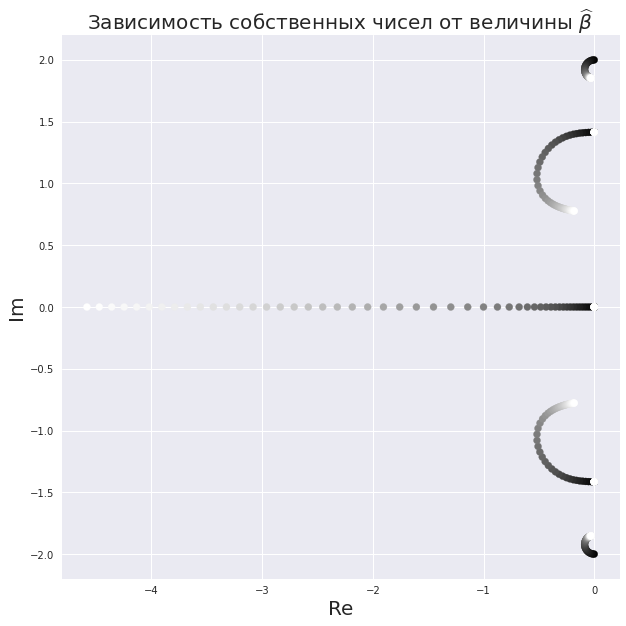

In [74]:
with plt.style.context("seaborn"):
    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(10)
    ax.set_title(r"Зависимость собственных чисел от величины $\widehat{\beta}$", fontsize=20)
    ax.set_xlabel("Re", fontsize=20)
    ax.set_ylabel("Im", fontsize=20)
    ax.scatter(np.real(roots[:, 1]), np.imag(roots[:, 1]), c=3- np.real(roots[:, 0]))

Чтобы найти время затухания я поступлю следующим способом: \
рассмотрю среднюю действительную часть у всех собственных значений, так как именно она отвечает за затухание, \
обозначу её за $\alpha$. Тогда время затухания будет $t_{затух} \approx -\frac{5}{\alpha}$

In [79]:
t_attenuation = -5 / (np.real(roots[:, 1].reshape(-1, 8)).mean(axis=1)[1:])

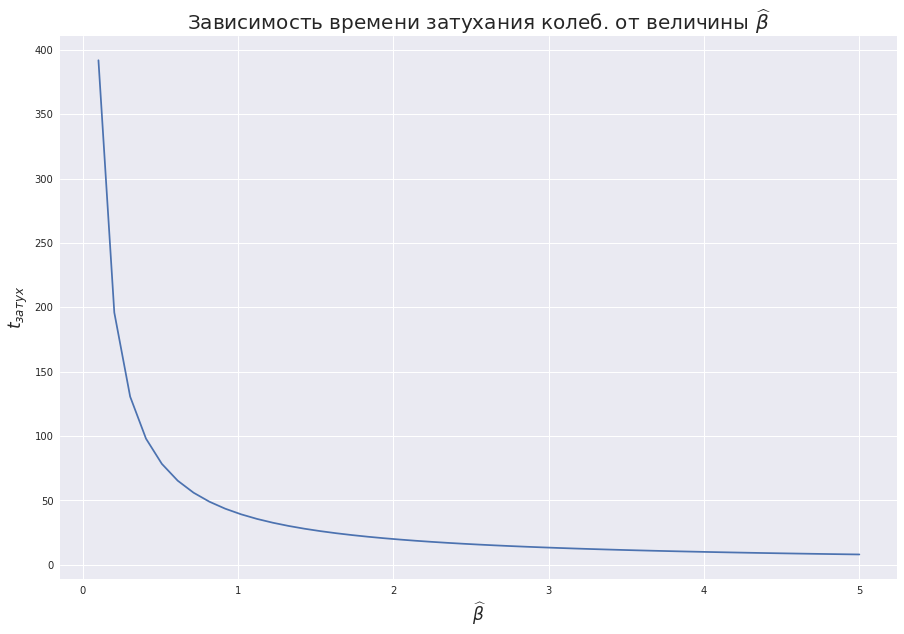

In [97]:
with plt.style.context("seaborn"):
    fig, ax = plt.subplots()
    ax.set_title(r"Зависимость времени затухания колеб. от величины $\widehat{\beta}$", fontsize=20)
    fig.set_figwidth(15)
    fig.set_figheight(10)
    ax.plot(beta_possible[1:], t_attenuation)
    ax.set_xlabel(r"$\widehat{\beta}$", fontsize=17)
    ax.set_ylabel(r"$t_{затух}$", fontsize=17)

Рассмотрим как вообще себя ведут координаты от времени при каких-то конкретных начальных условиях.

In [33]:
eq = Solution(1, 0.5, 2)
eq.solve((1, 0, -1, 0))

times = np.linspace(0, 30, 100)
coords = []
for t in times:
    coords.append(eq.q(t))

coords = np.array(coords)

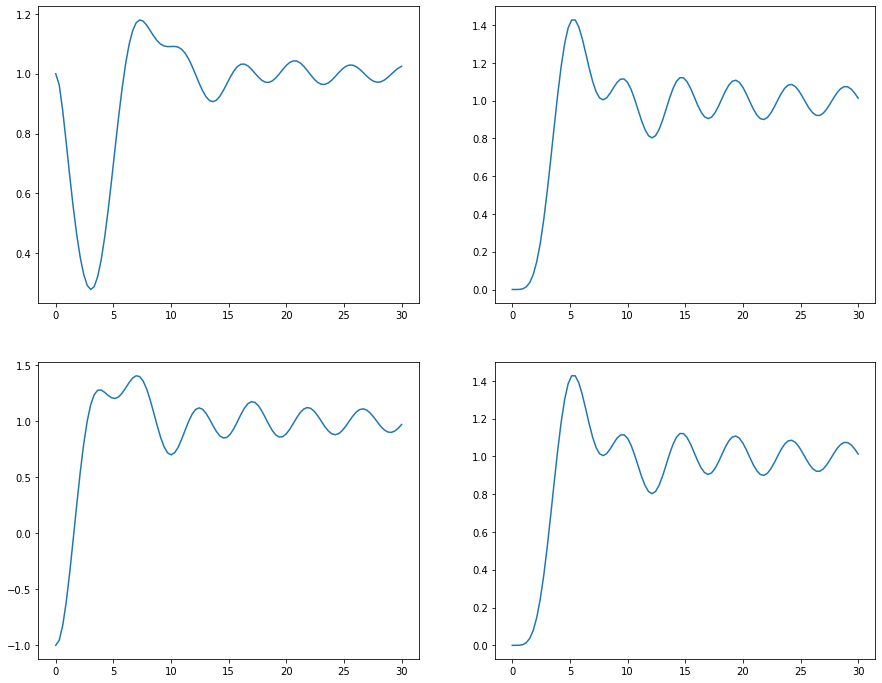

In [34]:
fig, axes = plt.subplots(2, 2)
fig.set_figwidth(15)
fig.set_figheight(12)

for i in range(4):
    axes[i // 2, i % 2].plot(times, np.real(coords[:, i]))